In [8]:
import pandas as pd
import numpy as np
import os
import gzip
import pickle
import re
import cycler
import tqdm

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Leitura do banco

In [2]:
data_dir = "./"
db_file = 'fundos.db'
engine = create_engine(
    "sqlite:///"+os.path.abspath(os.path.join(data_dir, db_file)))

data_inicio = '1500-02-26'
data_fim = '2017-12-31'
cnpj_fundo = '12.055.107/0001-16'  # ALASK BLACK

In [3]:
# cotas
sqlquery = """
select VL_QUOTA, DT_COMPTC from inf_diario
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
cotas = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC']).set_index(
    "DT_COMPTC")['VL_QUOTA'].sort_index()

In [4]:
# carteira e pesos
sqlquery = """
select * from cda
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
carteira = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])
pl = carteira.sort_values(['DT_COMPTC', 'FILE'])[
    'VL_PATRIM_LIQ'].fillna(method='bfill')
carteira['VL_PATRIM_LIQ'] = pl
carteira['peso'] = carteira['VL_MERC_POS_FINAL'].div(carteira['VL_PATRIM_LIQ'])

carteira = carteira[carteira.FILE != 'PL']

# Valores a pagar são negativos
q = (carteira.TP_APLIC == 'Valores a pagar') | (
    carteira.TP_APLIC.str.lower().str.contains('obriga|lançad'))
carteira.loc[q, ['VL_MERC_POS_FINAL', 'peso']] *= -1

pivot_cols = carteira.CD_ATIVO\
    .fillna(carteira.CD_ISIN)\
    .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Ação|Ações|Outr|Recibo|BDR", flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'([A-Z]{4,5}\d+\d?)', expand=False))\
    .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Opção|Opcões", flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'([A-Z]{4,5}\d+\d?)', expand=False))\
    .fillna(carteira[carteira.TP_ATIVO.str.contains("Debênture", flags=re.IGNORECASE)].CD_INDEXADOR_POSFX)\
    .fillna(carteira[carteira.TP_APLIC.str.lower().isin(['disponibilidades', 'valores a pagar', 'valores a receber'])].TP_APLIC.str.upper())\
    .fillna(carteira[carteira.TP_ATIVO.str.contains('T.tulo p.blico federal', flags=re.IGNORECASE)].DS_ATIVO.str.extract("(BR..........)", expand=False))\
    .fillna(carteira[carteira.TP_ATIVO.str.contains('T.tulo p.blico federal', flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'(\d{6})', expand=False))\
    .fillna(carteira.CNPJ_FUNDO_COTA)\
    .fillna(carteira.CD_ATIVO_BV_MERC)\
    .fillna(carteira[(carteira.TP_ATIVO.str.contains(r'Contrato Futuro.*', flags=re.IGNORECASE)) & (carteira.DS_ATIVO.str.contains('IND'))].DS_ATIVO.str.extract('(IND)', expand=False))\
    .fillna(carteira.DS_ATIVO)
print("Ativos sem identificação:", pivot_cols.isna().sum())

Ativos sem identificação: 0


In [5]:
sqlquery = """
SELECT CNPJ_FUNDO,DT_COMPTC, VL_QUOTA from inf_diario
WHERE CNPJ_FUNDO in ('{cnpj_fundos}')
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
fundos_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])

In [6]:
# acoes
sqlquery = """
select * from cotacoes
WHERE CODNEG in ('{ativos}')
OR CODISI in ('{ativos}')
and DATA >= '{data_inicio}'
and DATA <= '{data_fim}'
""".format(ativos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
acoes_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DATA'])

In [10]:
# ajustes desdobramentos
grupamentos = pd.read_parquet("../Dados/grupamentos.parquet")
grupamentos.loc[grupamentos.iloc[:,0] == 'DESDOBRAMENTO', '% / Fator de Grupamento'] = grupamentos.loc[grupamentos.iloc[:,0] == 'DESDOBRAMENTO', '% / Fator de Grupamento'].div(100).add(1)
grupamentos = grupamentos[grupamentos.Proventos.isin(['GRUPAMENTO','DESDOBRAMENTO'])]

for data, fator, ativo in tqdm.tqdm_notebook(grupamentos[grupamentos['Código ISIN'].isin(acoes_qry.CODISI.unique())].iloc[:,[3,4,5]].to_records(index=False)):
    print('ajustando', ativo, data, fator, end='\r'+(' ' * 50))
    q = (acoes_qry.CODISI == ativo) & (acoes_qry.DATA <= data)
    c = ['PREABE', 'PREMAX', 'PREMIN', 'PREMED', 'PREULT','PREOFC', 'PREOFV']
    acoes_qry.loc[q,c] = acoes_qry.loc[q,c].div(fator)

                                                  00 20.0ajustando BRALPAACNPR7 2005-06-08T00:00:00.000000000 0.01ajustando BRBBDCACNPR8 2009-06-08T00:00:00.000000000 50.0ajustando BRBBDCACNPR8 2009-06-08T00:00:00.000000000 0.02ajustando BRBBASACNOR3 2007-06-01T00:00:00.000000000 3.0ajustando BRBBASACNOR3 2004-01-23T00:00:00.000000000 0.001ajustando BRBRMLACNOR9 2010-09-23T00:00:00.000000000 2.0ajustando BRBRPRACNOR9 2010-02-03T00:00:00.000000000 0.25ajustando BRBRAPACNPR2 2005-04-29T00:00:00.000000000 2.0ajustando BRBRAPACNPR2 2004-07-02T00:00:00.000000000 2e-05ajustando BRBBRKACNOR4 2018-09-17T00:00:00.000000000 0.1ajustando BRBBRKACNOR4 2008-08-06T00:00:00.000000000 100.0ajustando BRBRKMACNPA4 2005-05-13T00:00:00.000000000 0.004ajustando BRBRKMACNPA4 2003-10-20T00:00:00.000000000 20.0ajustando BRBRFSACNOR8 2010-03-31T00:00:00.000000000 2.0ajustando BRELETACNOR6 2007-08-17T00:00:00.000000000 0.002ajustando BRELETACNPB7 2007-08-17T00:00:00.000000000 0.002ajustando BRELETACNOR6 1997-12

In [11]:
# Titulos
sqlquery = """
select * from titulos_publicos
WHERE CODISI in ('{ativos}')
OR CODIGO in ('{ativos}')
and DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
""".format(ativos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
titulos_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])

In [12]:
# Futuros
sqlquery = """
select DATE as DT_MOV, substr(MERCADORIA,0,4) || 'F' || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO, PRECO_ATUAL from futuros
WHERE DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
and substr(MERCADORIA,0,4) || 'F' || VENCIMENTO in ('{ativos}')
""".format(data_inicio=data_inicio, data_fim=data_fim, ativos="','".join(pivot_cols.unique()))
futuros_qry = pd.read_sql_query(sqlquery, engine, parse_dates=[
                                'DT_MOV'])  # .pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE').groupby(dict(futuros_carteira), axis=1).mean()
#futuros_qry[['MERCADORIA','MES_VENCIMENTO', 'ANO_VENCIMENTO']] = futuros_qry.CODIGO.str.extract(r"(.*)_(.)(..)")

In [13]:
# Indice Futuro
sqlquery = """
select DATE as DT_MOV, MERCADORIA,substr(MERCADORIA,0,4) || 'F' || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO, PRECO_ATUAL from futuros
WHERE DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
and MERCADORIA == 'IND - Ibovespa'
""".format(data_inicio=data_inicio, data_fim=data_fim)
ibovfut_query = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])

# Calcula os retornos dos ativos e dos títulos

In [14]:
retornos_acoes = acoes_qry.query("TPMERC == 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()
retornos_titulos = titulos_qry.pivot_table(index='DT_MOV', columns='CODISI', values='VALOR_PAR').pct_change()
retornos_opcoes = acoes_qry.query("TPMERC != 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()
retornos_fundos = fundos_qry.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO',values='VL_QUOTA').pct_change()
retornos_futuros = futuros_qry.pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE')
retornos_ibov = ibovfut_query.pivot_table(index='DT_MOV', columns='CODIGO', values='VARIACAO').div(100000).mean(1)

### Ativos na carteira sem série de retornos

In [15]:
sem_id = set(pivot_cols) - set(retornos_acoes) - set(retornos_titulos) - \
    set(retornos_opcoes) - set(retornos_fundos) - set(retornos_futuros)
print(len(sem_id), "ativos sem séries de retorno.", '\n\r', '\n, '.join(sorted(sem_id)))

49 ativos sem séries de retorno. 
 ALIANSCE SHOPPING CENTERS SA
, AMBEV S.A.
, BOVESPA
, BR PROPERTIES SA
, BRASKEM S/A
, DI1
, DISPONIBILIDADES
, DOLVFHDH    FHDH
, DOLVNJDF    NJDF
, DOLVNJDH    NJDH
, DOLVNJDJ    NJDJ
, DOLVNJDM    NJDM
, DOLVNJDS    NJDS
, DOLVQJFH    QJFH
, DOLVUJFG    UJFG
, DOLVUJFH    UJFH
, DOLVUJHB    UJHB
, DOLVUJHC    UJHC
, DOLVVJFM    VJFM
, DOLVVJFY    VJFY
, EMBRAER SA
, FIBRIA CELULOSE S/A
, HRT PARTICIPAÇÕES EM PETROLEO S/A
, IGUATEMI EMPRESA DE SHOPPING CENTER
, IND
, ITAU UNIBANCO HOLDING S.A.
, KLABIN SA I
, LVMGD3
, LVMGF0
, LVUJF9
, MAGAZINE LUIZA
, MARCOPOLO (RS)
, OGX PETROLEO E GAS PARTICIPACOES S.
, OGX PETROLEO E GAS PARTICIPAÇÕES S/
, OLCNG8
, OLCNJ89
, OLCQG8
, OLCQG84
, OLCUJ9
, PCARD06
, PETROBRAS
, RANDON PARTICIPACOES
, SUZANO PAPEL E CELULOSE SA
, TITULOS PERPETUOS DE REMUNERACAO VARIAVEL BASEADA ROYALTIES
, ULTRAPAR PARTICIPAÇÕES S/A
, VALE S/A
, VALID SOL E SERV DE SEG EM MEIOS
, VALORES A PAGAR
, VALORES A RECEBER


In [16]:
n_ativos = pivot_cols.nunique()
n_ativos_sem_id = len(sem_id)

# Agrupamento das ações por classe e agrupamento dos pesos

In [17]:
retornos_acoes_empresa = retornos_acoes.groupby(lambda s: s[0:4], axis=1).median().replace(0,np.nan)

In [ ]:
# tratamento outliers
q = retornos_acoes_empresa.abs() < retornos_acoes_empresa.std()*6
retornos_acoes_empresa = retornos_acoes_empresa[q].fillna(
    retornos_acoes_empresa.rolling(3, center=True).median())

In [25]:
agrupamentos = retornos_acoes.groupby(lambda s: s[0:4], axis=1).count().max()
agrupamentos = agrupamentos[agrupamentos > 1].sort_values()
agrupamentos[~agrupamentos.index.isin(retornos_acoes_empresa.columns)]

Series([], dtype: int64)

In [26]:
# Calcula pesos da carteira
pesos = carteira.pivot_table(
    index='DT_COMPTC', columns=pivot_cols, values='peso', aggfunc='sum')

# ajusta os títulos que foram listados apenas com a selic no bloco_8 do relatório à CVM
cod_selic_codigo_ISI_map = dict(
    titulos_qry[['CODIGO', 'CODISI']].drop_duplicates().applymap(str).values)
pesos.rename(columns=cod_selic_codigo_ISI_map, inplace=True)

In [27]:
# agrupa acoes
classes = pd.read_excel("classificao_acoes.xlsx", encoding='latin1')
classes.columns = ['SETOR', 'SUBSETOR',
                   'SEGMENTO', 'EMPRESA', 'CODIGO', 'SEGMENTO.1']
classes_acoes = dict(classes[['CODIGO', 'SETOR']].values)
mapper = pd.Series(dict(zip(retornos_acoes.columns.str.slice(0,4),
                  retornos_acoes.columns.str.slice(0, 4).map(classes_acoes.get))))

pesos_acoes = pesos.reindex(columns=retornos_acoes.columns).fillna(0).groupby(lambda s: s[:4], axis=1).sum()
pesos_agregados_acoes = pesos_acoes.groupby(mapper, axis=1).sum()

retornos_agregados_acoes = retornos_acoes_empresa.groupby(mapper, axis=1).mean()

In [28]:
# agrupa titulos
pesos_titulos = pesos.reindex(columns=retornos_titulos.columns).fillna(0)
pesos_agregados_titulos = pd.Series(pesos_titulos.sum(1), name='Titulos')

retornos_agregados_titulos = pd.Series(
    retornos_titulos.mean(1), name='Titulos')

In [29]:
pesos_opcoes_conhecidas = pesos.reindex(columns=retornos_opcoes.columns)
pesos_agregados_opcoes_conhecidas = pd.Series(pesos_opcoes_conhecidas.sum(axis=1), name='Opções')

pesos_desconhecidos = pesos.reindex(columns=sem_id)
pesos_agregados_desconhecidos = pd.Series(pesos_desconhecidos.sum(axis=1), name='Desconhecidos')

pesos_fundos = pesos.reindex(columns=retornos_fundos.columns)
pesos_agregados_fundos = pd.Series(pesos_fundos.sum(axis=1), name='Fundos')

#IBOV
pesos_ibov = pesos.reindex(columns=['IND']).fillna(0)
retornos_ibov = pd.Series(retornos_ibov, name='IND')

# FUTUROS
pesos_futuros = pesos.reindex(columns=retornos_futuros.columns).fillna(0)
pesos_agregados_futuros = pesos_futuros.groupby(lambda c: c[0:4], axis=1).sum()
retornos_agregados_futuros = retornos_futuros.groupby(lambda c: c[0:4], axis=1).mean()

In [30]:
n_ativos_unicos = pd.concat([pivot_cols,  carteira[['DT_COMPTC']]], axis=1).groupby('DT_COMPTC')['CD_ATIVO'].nunique()

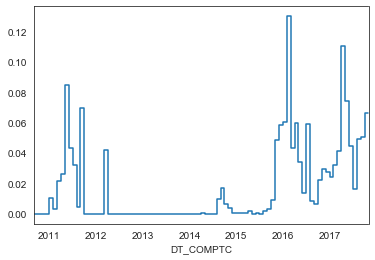

In [31]:
pesos_desconhecidos.drop(['DISPONIBILIDADES','VALORES A PAGAR','VALORES A RECEBER'], axis=1).sum(1).abs().plot(drawstyle='steps')

### Verifica se os dados contemplam todos ativos da carteira e se os pesos somam 1


# Filtro de Kalman
2 passos

In [32]:
pesos_agregados =  pd.concat([
    pesos_agregados_acoes,
    pesos_agregados_titulos,
    pesos_agregados_futuros,
    pesos_fundos, 
    pesos_ibov,
    pesos_agregados_desconhecidos
], axis=1)

retornos_agregados = pd.concat([
    retornos_agregados_acoes,
    retornos_agregados_titulos,
    retornos_agregados_futuros,
    retornos_fundos, 
    retornos_ibov,
    pd.Series().reindex_like(pesos_agregados_desconhecidos).fillna(0)
], axis=1)


In [33]:
# variacão da cota
measurements = ((cotas - cotas.shift())/cotas).dropna()
measurements = measurements.reindex(index=measurements.index.intersection(
    pd.date_range(pesos.index.min(), pesos.index.max())))

# estados
eom_pesos = pesos_agregados.resample('D').bfill().reindex(index=measurements.index).reindex(
    index=measurements.groupby(pd.Grouper(freq='M')).tail(1).index)
states = eom_pesos.reindex(
    columns=retornos_agregados.columns, index=measurements.index)

signals = retornos_agregados.reindex(
    index=measurements.index.values).fillna(method='pad')

In [34]:
# correlação de não se fazer nada
nome_fundo = carteira.DENOM_SOCIAL.unique()[0]
corr_fazer_nada = states.fillna(method='pad').mul(signals).sum(axis=1).corr(measurements).round(4)
data_inicio = measurements.index.min().strftime("%d-%m-%Y")
data_fim =  measurements.index.max().strftime("%d-%m-%Y")
n_cotas = len(measurements)
n_alocacoes = len(eom_pesos)

In [35]:
n_dim = len(states.columns)

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver, inv_diagonal
import tqdm

kf = KalmanFilter(n_dim,2+ n_dim)
kf.F *= 1
kf.Q *= np.sqrt(0.008*1e2)#0.31#2500


kf.x = eom_pesos.iloc[0].fillna(0).values
kf.P = np.zeros(kf.dim_x)


s = Saver(kf)
Hs = []
Rs = []
Zs = []
epss = []
for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements)):
    
    if dt in eom_pesos.index:
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x), np.ones(kf.dim_x)])
        R = np.eye(kf.dim_z) * 0.3
    else:
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x),  np.eye(kf.dim_x)*0, np.ones(kf.dim_x)]).astype(float)
        R = np.eye(kf.dim_z) * 0.3
        R[0,0] = 1e-2
        R[-1,-1] = 0.000001
    Z = np.hstack([measurements.loc[dt], states.loc[dt].fillna(0), 1])
    
    kf.H = H
    kf.R = R
    #kf.F = np.diag((1-H[0]).reshape(kf.dim_x))
    
    kf.predict()
    kf.update(Z)
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    
    epss.append(eps)
    
    s.save()

s.to_array()

estimativas = pd.DataFrame(s.x, index=measurements.index, columns=signals.columns)
corr_setor = (estimativas * signals).sum(axis=1).corr(measurements)

In [ ]:
from filterpy.kalman import rts_smoother
# Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

smooth = pd.DataFrame(sx, index=measurements.index, columns=signals.columns)
(smooth * signals).sum(axis=1).corr(measurements)

In [ ]:
# verifica o ativo
%matplotlib inline

ativo = 'Consumo não Cíclico'


erro_estimativa_ativo = pd.Series(s.y[:, 0], index=measurements.index).pow(2).div(s.S[:, 0, 0])


fig, ax = plt.subplots(2, 1, figsize=(30, 10), sharex=True, gridspec_kw=dict(
    height_ratios=[3, 1], hspace=0.2), facecolor='white')
estimativas.loc[:, ativo].plot(
    secondary_y=True, color='Blue', legend='peso', ax=ax[0], lw=.6)
smooth.loc[:, ativo].plot(secondary_y=True, color='Green',
                          legend='peso', ax=ax[0], lw=.6)
states[ativo].dropna().plot(marker='x', linestyle='', color='black',
                            markersize='15', secondary_y=True, ax=ax[0])
signals.loc[:, ativo].add(
    1).cumprod().plot(color='red', ax=ax[0])


import matplotlib.dates as mdates

ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle=':', lw=.5)

ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle=':', lw=.5)


erro_estimativa_ativo.plot(ax=ax[1])

[t.set_visible(True) for t in ax[0].get_xticklabels()]
ax[0].set_title("Estimativa do peso do ativo {} no portfolio".format(ativo))
handlers = ax[0].get_legend_handles_labels(
)[0] + ax[0].right_ax.get_legend_handles_labels()[0]
ax[0].legend(handlers, ["Preço do ativo", "Peso Estimado em % PL (Eixo Direito)",
                        "Peso reportado à CVM (Eixo direito)"], loc=2, bbox_to_anchor=(0, 1.2))
ax[1].legend(ax[1].get_legend_handles_labels()[
             0], ["Incerteza no Peso Estimado"])

In [ ]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
estimativas[(estimativas > 0)].reindex(columns=pesos_agregados.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
estimativas[(estimativas < 0)].reindex(
    columns=pesos_agregados.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=5, loc=8, bbox_to_anchor=(0.5, -0.5))

In [ ]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
smooth[(smooth > 0)].reindex(columns=pesos_agregados.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
smooth[(smooth < 0)].reindex(
    columns=pesos_agregados.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=5, loc=8, bbox_to_anchor=(0.5, -0.5))

In [ ]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
eom_pesos[(eom_pesos > 0)].reindex(columns=pesos_agregados.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
eom_pesos[(eom_pesos < 0)].reindex(
    columns=pesos_agregados.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=5, loc=8, bbox_to_anchor=(0.5, -0.5))

In [ ]:
erros = pd.Series(s.y[:, 0], index=measurements.index).pow(2).div(s.S[:, 0, 0])

fig, (axu, axd) = plt.subplots(nrows=2, ncols=1,
                               figsize=(20, 10), sharex=True, facecolor='white')
estimativas.mul(signals).sum(1).cumsum().plot(ax=axu)
measurements.cumsum().plot(ax=axu)
axur = axu.twinx()
(estimativas.mul(signals).sum(1) - measurements.T).plot(ax=axur, lw='0.1')
erros.plot(color='Blue', secondary_y=False, ax=axd)
print("Correlacao", estimativas.mul(signals).sum(1).corr(measurements))
axu.set_title("Cota do Fundo e Portfolio Estimado \n correlação: {}".format(
    estimativas.mul(signals).sum(1).corr(measurements)))
axd.set_title("Incerteza no valor da cota (P projetada no espaço das medidas)")
axu.legend(['Cota Estimada', 'Cota Real'])

In [ ]:
estimativas.sum(axis=1).plot()

## Kalman por setor

In [ ]:
cota_setor = estimativas * signals
setor = 'Consumo não Cíclico'

In [ ]:
estimations_2step = []
estimations_2step_smoothed = []
for setor in tqdm.tqdm_notebook(pesos_agregados_acoes.columns):
    measurements_setor = cota_setor[setor]
    pesos_setor = pesos_acoes.groupby(classes_acoes.get, axis=1).get_group(setor)
    signals_setor = retornos_acoes_empresa.reindex(
        columns=pesos_setor.columns).reindex(index=measurements_setor.index)

    eom_pesos_setor = pesos_setor.resample('D').bfill().reindex(index=measurements_setor.index).reindex(
        index=measurements_setor.groupby(pd.Grouper(freq='M')).tail(1).index)
    states_setor = eom_pesos_setor.reindex(
        columns=signals_setor.columns, index=measurements_setor.index)

    # Tratamento de outliers
    q = signals_setor < signals_setor.std()*3
    signals_setor = signals_setor[q].fillna(
        signals_setor.rolling(3, center=True).median())

    # correlação de não se fazer nada
    states_setor.fillna(method='pad').mul(
        signals_setor).sum(axis=1).corr(measurements_setor)

    n_dim = len(states_setor.columns)

    from filterpy.kalman import KalmanFilter
    from filterpy.common import Saver, inv_diagonal
    import tqdm

    kf = KalmanFilter(n_dim, 1 + n_dim)
    kf.F *= 1
    kf.Q *= np.sqrt(0.08)  # 0.31#2500

    kf.x = eom_pesos_setor.iloc[0].fillna(0).values
    kf.P = np.zeros(kf.dim_x)

    s = Saver(kf)
    Hs = []
    Rs = []
    Zs = []
    for i, dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements), leave=False):

        if dt in eom_pesos_setor.index:
            H_mask = (states_setor.loc[dt] != 0) * 1
            H = np.vstack([signals_setor.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x)])
            #H = np.vstack([signals_setor.loc[dt].fillna(0).values.reshape(1, kf.dim_x), np.eye(kf.dim_x)])
            R = np.eye(kf.dim_z) * 0.3 / 1
        else:
            H = np.vstack([signals_setor.loc[dt].fillna(0).values.reshape(1, kf.dim_x),  np.eye(kf.dim_x)*0]).astype(float)
            R = np.diag(np.hstack([5e-1, np.where(H_mask,5e-1,5e-1)]))
        #R[0, 0] = 0.0008
        #R[-1,-1] = 0.00000001

        Z = np.hstack([measurements_setor.loc[dt], states_setor.loc[dt].fillna(0)])

        kf.H = H
        kf.R = R
        #kf.F = np.diag((1-H[0]).reshape(kf.dim_x))

        kf.predict()
        kf.update(Z)

        s.save()

    s.to_array()

    estimativas_setor = pd.DataFrame(
        s.x, index=measurements_setor.index, columns=signals_setor.columns)
    (estimativas_setor * signals_setor).sum(axis=1).corr(measurements_setor)

    from filterpy.kalman import rts_smoother
    # Calcula as matrizes smoothed
    sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

    smooth_setor = pd.DataFrame(
        sx, index=measurements_setor.index, columns=signals_setor.columns)
    print(setor, ((smooth_setor * signals_setor).sum(axis=1).corr(measurements_setor)), end=",")
    estimations_2step.append(estimativas_setor)
    estimations_2step_smoothed.append(smooth_setor)

In [ ]:
result = pd.concat(estimations_2step, axis=1)
result = result.loc[:, ~result.columns.duplicated()]
result = pd.concat([result, smooth.iloc[:, -2:]], axis=1)

In [ ]:
corr_2_step = retornos_acoes_empresa.reindex_like(result).mul(result).sum(1).corr(cotas.pct_change())

In [ ]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
result[(result > 0)].plot.area(figsize=(20, 10), ax=axu, legend=None)
result[(result < 0)].plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=20, loc=8, bbox_to_anchor=(0.5, -0.5))

In [ ]:
setor = 'Consumo não Cíclico'
result_by_sector = result.loc[:,result.columns.map(classes_acoes.get) == setor]
reported_by_sector = eom_pesos.loc[:,eom_pesos.columns.map(classes_acoes.get) == setor]

def allocation_plot(result, reported):
    fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
    result[(result > 0)].fillna(0).plot.area(figsize=(20, 10), ax=axu, legend=None, cmap='tab20')
    
    result[(result < 0)].fillna(0).plot.area(figsize=(20, 10), ax=axd, cmap='tab20')
    
    reported[(reported > 0)].plot(figsize=(20, 10), ax=axu, legend=None, color='k', ls=' ', marker='.', stacked=True)
    reported[(reported < 0)].plot(figsize=(20, 10), ax=axd, legend=None, color='k', ls=' ', marker='.', stacked=True)
    
    axu.set_xticks([])
    axd.set_ylim(-axu.get_ylim()[1], 0)
    axd.legend(ncol=20, loc=8, bbox_to_anchor=(0.5, -0.5))
    return fig, (axu, axd)
allocation_plot(result_by_sector, reported_by_sector);

# 1 - Step

In [36]:
pesos_single_step =  pd.concat([
    pesos_acoes,
    pesos_titulos,
    pesos_futuros,
    pesos_fundos, 
    pesos_ibov,
    pesos_agregados_desconhecidos
], axis=1)

retornos_single_step = pd.concat([
    retornos_acoes_empresa,
    retornos_titulos,
    retornos_futuros,
    retornos_fundos, 
    retornos_ibov,
    pd.Series().reindex_like(pesos_agregados_desconhecidos).fillna(0)
], axis=1)

In [37]:
# variacão da cota
measurements = ((cotas - cotas.shift())/cotas).dropna()
measurements = measurements.reindex(index=measurements.index.intersection(
    pd.date_range(pesos.index.min(), pesos.index.max())))

# estados
eom_pesos = pesos_single_step.resample('D').bfill().reindex(index=measurements.index).reindex(
    index=measurements.groupby(pd.Grouper(freq='M')).tail(1).index)

signals = retornos_single_step.reindex(
    index=measurements.index.values)

states = eom_pesos.reindex(
    columns=signals.columns, index=measurements.index)

In [38]:
n_dim = len(states.columns)

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver, inv_diagonal
import tqdm

kf = KalmanFilter(n_dim,2+ n_dim)
kf.F *= 1
kf.P = np.diag([0]*kf.dim_x)
kf.Q *= np.sqrt(0.04)


kf.x = states.iloc[0].fillna(0).values
kf.P = np.zeros(kf.dim_x)

s = Saver(kf)
state_mask = np.zeros(kf.dim_x)
Hs = []
Rs = []
Zs = []
epss = []
for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements)):

    if dt in eom_pesos.index:
        state_mask = states.replace(0,np.nan).fillna(method='bfill', limit=1)
        state_mask = state_mask.isnull().mul(1).loc[dt].values
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x), np.ones(kf.dim_x)])
        R = np.eye(kf.dim_z)*1e-3
    else:
        #kf.H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,n_dim), np.diag(state_mask)]).astype(float)
        #kf.R = np.diag(np.hstack([np.array(1e-2), (state_mask * 0.05) + np.finfo(np.double).tiny])).astype(float)
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x),  np.diag(state_mask), np.ones(kf.dim_x)]).astype(float)
        R = np.eye(kf.dim_z) * 0.3
        R[0,0] = 1e-3
        R[0,0] = 1e-5
    
    Z = np.hstack([measurements.loc[dt], states.loc[dt].fillna(0), 1])
    kf.H = H
    kf.R = R
    
    kf.predict()
    kf.update(Z)
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    s.save()
    #Hs.append(H)
    #Rs.append(R)
    #Zs.append(Z)

In [39]:
estimativas = pd.DataFrame(s.x, index=measurements.index, columns=signals.columns)
corr_single_step = (estimativas * signals).sum(axis=1).corr(measurements)

Fundo | Correlacao <br> constante | Data <br> Inicio | Data <br> Fim | # <br> cotas | # <br> alocaçoes | Correlação <br> Setor | Correlação <br> 2 Passos | Correlação <br> 1 Passo
:--------:|:--------------:|:-------------:|:----------:|:---------:|:-------------:|:----:|:---:|:---:|
{{nome_fundo}}| {{corr_fazer_nada}} | {{data_inicio}} | {{data_fim}} | {{n_cotas}} | {{n_alocacoes}} | {{corr_setor.round(4)}} | {{corr_2_step.round(4)}} | {{ corr_single_step.round(4)}}

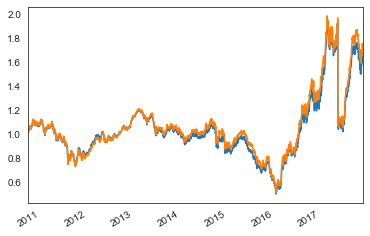

In [40]:
(estimativas * signals).sum(axis=1).add(1).cumprod().plot()
measurements.add(1).cumprod().plot()

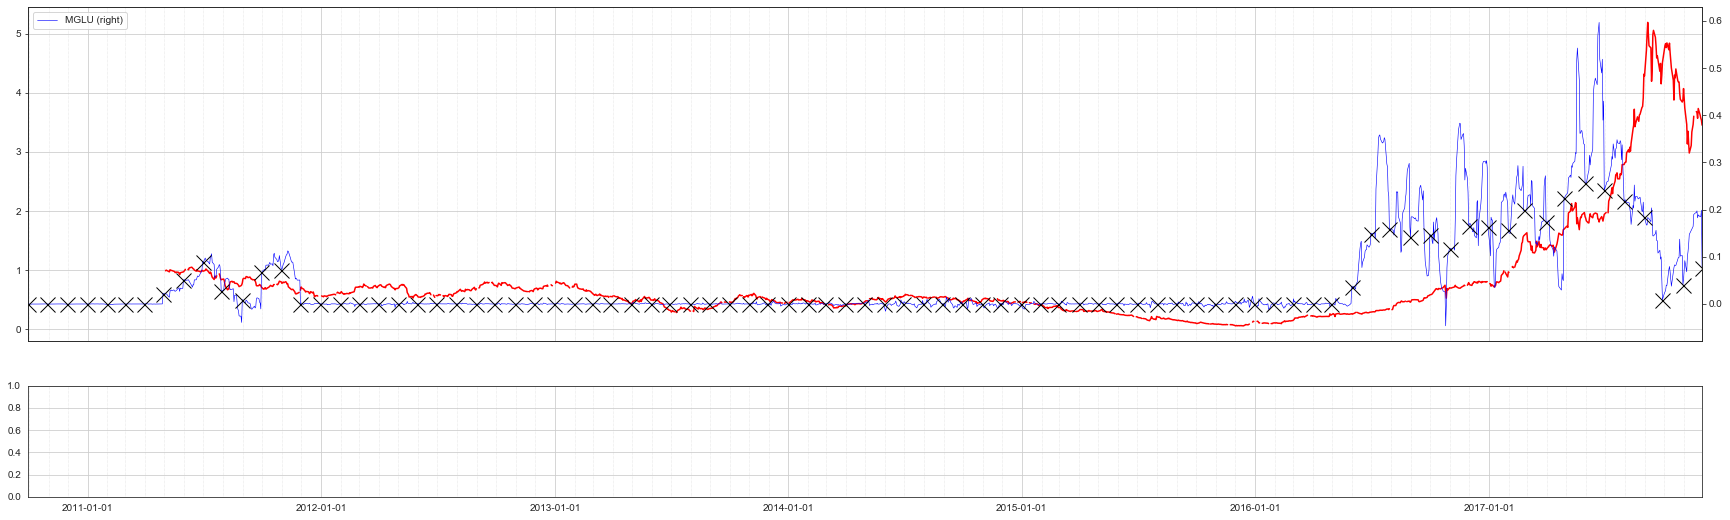

In [41]:
# verifica o ativo
%matplotlib inline

ativo = 'MGLU'

fig, ax = plt.subplots(2, 1, figsize=(30, 10), sharex=True, gridspec_kw=dict(
    height_ratios=[3, 1], hspace=0.2), facecolor='white')
estimativas.loc[:, ativo].plot(
    secondary_y=True, color='Blue', legend='peso', ax=ax[0], lw=.6)

states[ativo].dropna().plot(marker='x', linestyle='', color='black',
                            markersize='15', secondary_y=True, ax=ax[0])
signals.loc[:, ativo].add(
    1).cumprod().plot(color='red', ax=ax[0])


import matplotlib.dates as mdates

ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle=':', lw=.5)

ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle=':', lw=.5)



In [ ]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
estimativas[(estimativas > 0)].reindex(columns=states.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
estimativas[(estimativas < 0)].reindex(
    columns=states.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=15, loc=8, bbox_to_anchor=(0.5, -1.0))

In [ ]:
setor = 'Consumo não Cíclico'
result_by_sector = estimativas.loc[:,estimativas.columns.map(classes_acoes.get) == setor]
reported_by_sector = eom_pesos.loc[:,eom_pesos.columns.map(classes_acoes.get) == setor]

def allocation_plot(result, reported):
    fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
    result[(result > 0)].fillna(0).plot.area(figsize=(20, 10), ax=axu, legend=None, cmap='tab20')
    
    result[(result < 0)].fillna(0).plot.area(figsize=(20, 10), ax=axd, cmap='tab20')
    
    reported[(reported > 0)].plot(figsize=(20, 10), ax=axu, legend=None, color='k', ls=' ', marker='.', stacked=True)
    reported[(reported < 0)].plot(figsize=(20, 10), ax=axd, legend=None, color='k', ls=' ', marker='.', stacked=True)
    
    axu.set_xticks([])
    axd.set_ylim(-axu.get_ylim()[1], 0)
    axd.legend(ncol=20, loc=8, bbox_to_anchor=(0.5, -0.5))
    return fig, (axu, axd)
allocation_plot(result_by_sector, reported_by_sector);

In [ ]:
x = signals['MGLU']
st = x.std()

In [ ]:
#signals['MGLU'].add(1).cumprod().sub(1).plot()
pd.read_csv("C:/Users/pablo/Downloads/MGLU3.SA.csv", parse_dates=['Date']).set_index('Date')['Adj Close'].pct_change().add(1).cumprod().sub(1).plot(color='green')
krt = acoes_qry.query("CODNEG == 'MGLU3'").set_index('DATA')['PREULT'].div(100).pct_change()
q = krt.abs() < krt.rolling(180, center=True).std() * 3
krt[q].fillna(krt.rolling(3, center=True).median()).add(1).cumprod().sub(1).plot(color='red')

In [ ]:
a = pd.read_csv("C:/Users/pablo/Downloads/MGLU3.SA.csv", parse_dates=['Date']).set_index('Date')['Adj Close'].pct_change()

In [ ]:
ax = a.plot(figsize=(20,10))
a.rolling(180, center=True).std().mul(3).plot(color='orange')
a.rolling(180, center=True).std().mul(-3).plot(color='orange')
a.ewm(halflife=10).mean().mul(3).plot(color='green')
ax.axhline(a.std()*3)
ax.axhline(a.std()*-3)

In [ ]:
a